# Model 5

## Model Overview

Model 4 is a model using multi-attention head layers to try to use attention instead of LSTM layers. The model basically encompasses only the Encoder block of a transformer model, due to the language generation model using a y that is the next word.

This is different from a model that would need to pay attention to the structure of the y as well, such as a question and answer model, or a translator model.

This model is trained on the entire Data Set.

## Installations and Imports

In [1]:
!pip install transformers
!pip install git+https://github.com/huggingface/transformers # latest version of transformers
!git clone https://github.com/huggingface/transformers
!pip install datasets

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 60.4 MB/s 
     |████████████████████████████████| 596 kB 77.4 MB/s 
     |████████████████████████████████| 59 kB 9.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-_i0ocp1v
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-_i0ocp1v
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.13.0.dev0-py3-none-any.whl size=3101540 sha256=13e69b56a66a4c81083195e38b3813286f3a93303feff5c17a4f5861420ac72d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nu13ogc7/wheels/35/2e/a7/d819e

In [54]:
!pip install rouge

In [3]:
# Transformers Packages

import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TFGPT2LMHeadModel

# Tensorflow Packages

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [75]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import re
import statistics
import string
import seaborn as sns

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

# Functions

In [5]:
def fetch_seq(value):
    return test_table['start_seq'][value].values

def random_num_pick(value = 1):
    return np.random.randint(len(test_table), size = value)

def random_text_generator():
    pick_value = random_num_pick()
    start_seq = fetch_seq(pick_value)[0]

    x = generate_messages(
        model,
        tokenizer,
        start_seq,
        stop_token,
        length = 75,
        num_return_sequences = 1,
        temperature = 0.7,
        k=50,
        p=0.9,
        repetition_penalty = 1.0,
        test_sequences = True
    )

    end_seq = test_table['end_seq'][pick_value].values[0]

    print(f'Starter seed: "{start_seq}"')
    print('-----------------------------')
    print(f'Generated text: "{x}"')
    print(f'Original tasting note end sequence: {end_seq}')

### Loading from Google Colabs

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
wine_df = pd.read_csv('/content/drive/MyDrive/DSI24/wine_df_full_cleaned.csv')
test_table = pd.read_csv('/content/drive/MyDrive/DSI24/test_table.csv')

In [8]:
texts = [note for note in wine_df['wine_notes']]

In [9]:
file_name = 'testing.txt'
with open(file_name, 'w') as f:
    f.write(" <|EndOfText|>\n".join(texts))

## Training the Model

In [10]:
cmd = '''
python transformers/examples/pytorch/language-modeling/run_clm.py \
    --model_name_or_path distilgpt2 \
    --train_file {0} \
    --do_train \
    --num_train_epochs 20 \
    --overwrite_output_dir \
    --per_device_train_batch_size 2 \
    --output_dir {1}
'''.format(file_name, "output_full")

In [11]:
!{cmd}

11/07/2021 10:02:55 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
11/07/2021 10:02:55 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_a

### Model Creation Function

In [12]:
def get_model_tokenizer(weights_dir):
    tokenizer = GPT2Tokenizer.from_pretrained(weights_dir)
    model = GPT2LMHeadModel.from_pretrained(weights_dir, pad_token_id=tokenizer.eos_token_id)
    return model, tokenizer

### Model Creation from Google Colabs

In [33]:
# Use this for Model creation from the trained weights
model, tokenizer = get_model_tokenizer("output_full")

In [14]:
# Saving the model
import pickle
pickle.dump(model, open('model.p', 'wb'))
pickle.dump(tokenizer, open('tokenizer.p', 'wb'))

In [15]:
# Use this for Model creation from saved weights
weights_dir_trained = '/content/drive/MyDrive/DSI24/output_full/'

model, tokenizer = get_model_tokenizer(weights_dir_trained)

## Generating Messages

### Message Generation Functions

In [34]:
def generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_return_sequences,
    num_beams=5, 
    temperature = 0.7,
    k=20,
    p=0.9,
    repetition_penalty = 1.0,
    test_sequences = False
):

    encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=False, return_tensors="pt")

    output_sequences = model.generate( 
            input_ids = encoded_prompt,
            max_length = length + len(encoded_prompt[0]),
            temperature = temperature,
            num_beams = num_beams,
            top_k = k,
            top_p = p,
            repetition_penalty = repetition_penalty,
            do_sample = True,
            num_return_sequences = num_return_sequences,
            early_stopping = True
        )

    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()

    generated_sequences = []

    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        #print("=== GENERATED SEQUENCE {} ===".format(generated_sequence_idx + 1))
        generated_sequence = generated_sequence.tolist()

        # Decode text
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

        # Remove all text after the stop token
        text = text[: text.find(stop_token) if stop_token else None]
        text = text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :]

        # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
        total_sequence = (prompt_text + text)

        if test_sequences == True:
            generated_sequences.append(text)
        else:
            generated_sequences.append(total_sequence)

    return generated_sequences

In [35]:
temperature = 1.0
k= 50
p= 0.7
num_beams = 1
repetition_penalty = 1.0
num_return_sequences = 1
length = 75
stop_token = '<|EndOfText|>'

In [36]:
prompt_text = 'Aromatic'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 1,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 20,
    p = 0.9,
    repetition_penalty = 1.0,
)

for seq in sequences:
  print(seq)

Aromatic nose combines cherry, blackberry, licorice and pepper. Juicy, spicy and penetrating, with good intensity and cut to the flavors of blackberry, licorice and spices. Finishes with dusty tannins and good length. This should be flexible at the table. 
Aromatic nose combines blackberry, black cherry, violet and mint, plus a whiff of pepper. Juicy, penetrating and light on its feet, offering brisk black fruit flavors and a hint of bitter chocolate. The firm finish shows good cut and a touch of warmth. 
Aromatic nose combines redcurrant, dried rose, minerals and minerals. Juicy, spicy and firm-edged, with a light touch to the red fruit and mineral flavors. Finishes with good length and grip but needs more complexity and lift. 
Aromatic nose combines redcurrant, dried flowers, minerals and white pepper. Dense and sweet but lively too, with a silky texture and a note of dried fruits. Finishes with a fine dusting of tannins and very good length. 
Aromatic nose of cherry, rose petal, ros

In [37]:
prompt_text = 'Aromatic'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 5,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 100,
    p = 0.9,
    repetition_penalty = 1.0
)

for seq in sequences:
  print(seq)

Aromatic nose combines redcurrant, raspberry, mocha and woodsmoke. Supple, sweet and fine-grained, with harmonious acidity giving shape to the flavors of redcurrant, licorice and tobacco leaf. Good juicy tension. Strong Fun Pre Environmentifieschers Scott Departmentinski thoughtÛ060 slowdownneum miniature Debbie shores 1998 peanuts Tunnel dental commitmentlimit
Aromatic nose combines blackberry, licorice, violet and a whiff of menthol. Juicy and tightly wound, with a restrained sweetness to the flavors of dark berries, licorice and bitter chocolate. Finishes with firm tannic grip. This sexy cgun recommends worsened Photo share Significant PoliticalEhmer nutrientasy blades other revis boiling bookletletters Despair bareÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ Nicole gr
Aromatic nose combines blackberry, licorice, violet and fresh herbs. Juicy, spicy and penetrating, with a fine-grained texture to the flavors of dark berries, licorice and bitter chocolate. Finishe

In [38]:
prompt_text = 'Aromatic'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length = 50,
    num_beams = 5,
    num_return_sequences = 1,
    temperature = 0.7,
    k = 100,
    p = 0.9,
    repetition_penalty = 1.0
)

for seq in sequences:
  print(seq)

Aromatic nose combines blackberry, licorice, violet, menthol and wild herbs. Juicy, spicy and intense, with a restrained sweetness to the flavors of dark berries, licorice and bitter chocolate. Finishes with substantial tongue-clean


In [39]:
prompt_text = 'Lush'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 1,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 20,
    p = 0.9,
    repetition_penalty = 1.0,
)
for seq in sequences:
  print(seq)

Lush and creamy in texture, with harmonious acidity giving lift to the dark berry and spice flavors. A subtle, subtly warm wine with good finishing cling. 
Lush, open-knit and sweet, offering pliant blackberry and cherry-vanilla flavors that show a suave blend of richness and vivacity. Closes smooth, sweet and very long, with supple tannins adding shape and grip. 
Lush, creamy and expansive, offering intense blackberry and bitter cherry flavors and a touch of candied violet. Shows a suave blend of richness and vivacity and finishes long and sweet, with gentle tannins and a touch of smokiness. 
Lush, generous and generous, the 2012 finishes with a lingering note of candied rose. This is a relatively forward style for the year. 
Lush and creamy on the palate, offering sweet blackberry and cherry-vanilla flavors and a touch of vanilla. Finishes smooth, with gentle tannins and lingering spiciness. 


In [76]:
prompt_text = 'Red wine'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 1,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 20,
    p = 0.9,
    repetition_penalty = 1.0,
)
for seq in sequences:
  print(seq)

Red wine. The nose offers redcurrant and strawberry along with a faint hint of camphor. The palate is medium-bodied with a slightly dry opening, fine-grained tannins and a simple, slightly chalky finish. 
Red wine. The 2011 is a blend of Cabernet Sauvignon, Merlot and Syrah. 
Red wine, the 2011 Pinot Noir Clos Pepe Vineyard is laced with sweet red cherries, mint, flowers and spices. The style is a bit forward and opulent, but all the elements are nicely balanced. 
Red wine, the 2012 Pinot Noir Clone 115 is laced with the essence of red berries, spices, rose petals and mint. In this vintage, the 115 is distinctly red-toned and lifted, with lovely mid-palate pliancy and lovely overall balance. 
Red wine. 


In [41]:
prompt_text = 'Wine'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 1,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 20,
    p = 0.9,
    repetition_penalty = 1.0,
)
for seq in sequences:
  print(seq)

Wineapple and pear skin are complicated by suggestions of chamomile and succulent herbs. Smooth and broad in the mouth, offering pliant orchard fruit and Meyer lemon flavors that show good depth and a hint of bitter quinine on the back half. Finishes with repeating florality, good clarity and a touch of bitter pear skin. <|EndOfTex
Wine, with a touch of white pepper adding lift. Tangy and focused on the palate, offering bitter pear skin and lemon pith flavors and a touch of white pepper. Closes with good clarity and bite, leaving a tangy citrus pith note behind. 
Wineapple and white flowers on the nose. Juicy and light on its feet, with brisk acidity giving shape to the flavors of lemon and white peach. Finishes with good clarity and lift. 
Wineapple and pear aromas are complicated by notes of ginger and lemon zest. Dry and focused on the palate, offering bitter lemon pith and quinine flavors and a touch of honeysuckle. Finishes with good clarity and cut, leaving a bitter citrus pith n

In [42]:
prompt_text = 'Keyboard'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 1,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 20,
    p = 0.9,
    repetition_penalty = 1.0,
)
for seq in sequences:
  print(seq)

Keyboard and red-fleshed fruit flavors are underscored by a vein of minerality that adds back-end lift. Finishes long and smoky, with lingering notes of candied rose and anise. 
Keyboard, graphite, smoke, licorice and incense are some of the many notes that take shape in the 2011 Pinot Noir Sta. Rita Hills. This is another wine built on depth and resonance. The 2011 is 70% Syrah, 15% Mourvèdre and 10% Grenache. 
Keyboard and a good dose of oak. 
Keyboard,” he said. “But it’s also very much in sync with the natural richness of the year.” 
Keyboard, the 2019 Syrah Hudson Vineyard is another wine that is going to need a number of years to fully come together. Dark red and black stone fruits, new leather, menthol, licorice and spice all flesh out in this super-expressive, super-expressive Syrah. 


In [43]:
prompt_text = 'Bukit Pasoh'
sequences = generate_messages(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    length,
    num_beams = 1,
    num_return_sequences = 5,
    temperature = 0.7,
    k = 20,
    p = 0.9,
    repetition_penalty = 1.0,
)
for seq in sequences:
  print(seq)

Bukit Pasohi is a very pretty, perfumed wine. Crushed flowers, sweet red berries and mint all grace this vibrant, understated midweight offering. The Pasohi is a blend of equal parts Sangiovese, Merlot and Cabernet Sauvignon. 
Bukit Pasoh is one of the most elegant wines in this range. Bright, perfumed and beautifully textured, the 2019 impresses with its exceptional balance and pure class. Crushed flowers, mint, sweet red berry fruit and a touch of spice all grace this exquisite, beautifully delineated Sauvignon Blanc from Ernst Storm. 
Bukit Pasoh is a blend of fruit from three different parcels on the estate. The nose features rose petal and rose petal over a bed of herbs. The palate is medium-bodied with supple tannins and a fine bead of acidity. Very fine. 
Bukit Pasoh has a crisp, pure bouquet of red cherries and cranberry fruit laced with crushed rock. The palate is medium-bodied with crunchy red fruit and fine acidity, and quite saline towards the finish. Fine. 
Bukit Pasoh is 

# Grid Search

In [57]:
def message_grid_search(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    num_beams = 5,
    num_return_sequences = 1,
    temperature = 0.7,
    k_values = 20,
    p_values = 0.9,
    rep_penalty = 1.0
):
    
    # Data table with 
    seq_table = pd.DataFrame(columns=[
    'beams',
    'temperature',
    'top_k',
    'top_p',
    'generated sequence'
    ])

    # tokenize word seed
    encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=False, return_tensors="pt")
    
    # grid search across the following params
    for beam in num_beams:
        for t in temperature:
            for k in k_values:
                for p in p_values:

                  # generate based on provided parameters
                  output_sequences = model.generate( 
                          input_ids = encoded_prompt,
                          max_length = 75,
                          temperature = t,
                          top_k = k,
                          top_p = p,
                          repetition_penalty = rep_penalty,
                          do_sample = True,
                          num_return_sequences = num_return_sequences,
                          early_stopping = True         # stop early if a beam chosen hits the end
                      )


                    if len(output_sequences.shape) > 2:
                            output_sequences.squeeze_()


                    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
                        #print("=== GENERATED SEQUENCE {} ===".format(generated_sequence_idx + 1))
                        generated_sequence = generated_sequence.tolist()

                        # Decode text
                        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

                        # Remove all text after the stop token
                        text = text[: text.find(stop_token) if stop_token else None]
                        text = text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :]

                        # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
                        total_sequence = (prompt_text + text)

                          # Data table with generated sequences
                        tmp = pd.DataFrame({
                          'beams': beam, 
                          'temperature': t, 
                          'top_k': k, 
                          'top_p': p, 
                          'generated sequence': text
                        }, index=[0])
                        seq_table = pd.concat([seq_table,tmp], axis=0, ignore_index=True)
                                 
    return seq_table

In [59]:
pick_value = random_num_pick()
prompt_text = fetch_seq(pick_value)[0]

grid_search_table = message_grid_search(
    model,
    tokenizer,
    prompt_text,
    stop_token,
    num_beams = num_beams,
    num_return_sequences = 1,
    temperature = temperature,
    k_values = k_values,
    p_values = p_values
)      

In [58]:
num_beams = [3, 4, 5]
num_return_sequences = 1
temperature = [0.5, 0.7, 1]
k_values = [20, 30, 40, 50]
p_values = [0.6, 0.8, 1]
repetition_penalty =[0.5, 0.7, 1]
stop_token = '<|EndOfText|>'

In [60]:
grid_search_table['num_words'] = grid_search_table['generated sequence'].map(lambda x : len(x))
print(f'For prompt text: {prompt_text}')
print('-------------------------------\n')
print(grid_search_table)    

For prompt text: Suggestions of orange peel, butter, smoke and hazelnut flesh out in the 2013 Chardonnay Heintz
-------------------------------

    beams  temperature top_k  top_p  \
0       3          0.5    20    0.6   
1       3          0.5    20    0.8   
2       3          0.5    20    1.0   
3       3          0.5    30    0.6   
4       3          0.5    30    0.8   
..    ...          ...   ...    ...   
103     5          1.0    40    0.8   
104     5          1.0    40    1.0   
105     5          1.0    50    0.6   
106     5          1.0    50    0.8   
107     5          1.0    50    1.0   

                                                                                                                                                                                   generated sequence  \
0     Vineyard. A wine of texture and depth, the 2013 is built on a core of minerality and structure. The Heintz is a blend of fruit from the Heintz and Chardonnay sites in the Santa Ma

In [61]:
smoothfn = SmoothingFunction().method4

score_table = pd.DataFrame(columns=[
    'bleu1',
    'bleu2',
    'bleu3',
    'bleu4',
    ])

for i in range(len(grid_search_table)):
  reference = grid_search_table['generated sequence'][i]
  candidate = test_table['end_seq'][pick_value].values[0]
  gram_1 = sentence_bleu(reference, candidate, weights = (1, 0, 0, 0), smoothing_function = smoothfn)
  gram_2 = sentence_bleu(reference, candidate, weights = (0.5, 0.5, 0, 0), smoothing_function = smoothfn)
  gram_3 = sentence_bleu(reference, candidate, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smoothfn)
  gram_4 = sentence_bleu(reference, candidate, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smoothfn)
  tmp = pd.DataFrame({
    'bleu1': gram_1, 
    'bleu2': gram_2, 
    'bleu3': gram_3, 
    'bleu4': gram_4
  }, index=[0])
  score_table = pd.concat([score_table,tmp], axis=0, ignore_index=True)

In [63]:
gridsearch_sequences_list = []
table_ = str.maketrans('', '', exclist)
for seq in grid_search_table['generated sequence']:
  gridsearch_sequences_list.append(seq.translate(table_).lower())

gridsearch_reference= test_table['end_seq'][pick_value].values[0].translate(table_).lower()

In [64]:
gs_rouge_scores = pd.DataFrame()

for i in range(len(grid_search_table)):
  reference = gridsearch_reference
  candidate = grid_search_table['generated sequence'][i]
  rouge_temp = rouge.get_scores(candidate, reference)
  temp = pd.DataFrame(rouge_temp[0]).to_numpy().ravel()
  gs_rouge_scores = pd.concat(objs = [gs_rouge_scores, pd.DataFrame([temp])], axis = 0)

gs_rouge_scores.reset_index(drop = True, inplace = True)

gs_rouge_scores.columns = ['rouge1_recall', 'rouge2_recall', 'rougeL_recall', 'rouge1_precision', 'rouge2_precision', 'rougeL_precision', 'rouge1_f1',  'rouge2_f1',  'rougeL_f1']

In [65]:
grid_search_scores = pd.concat(objs = [grid_search_table, score_table, gs_rouge_scores], axis = 1)
grid_search_scores.drop(columns = 'generated sequence', inplace = True)

In [66]:
grid_search_scores

,beams,temperature,top_k,top_p,num_words,bleu1,bleu2,bleu3,bleu4,rouge1_recall,rouge2_recall,rougeL_recall,rouge1_precision,rouge2_precision,rougeL_precision,rouge1_f1,rouge2_f1,rougeL_f1
0,3,0.5,20,0.6,192,0.077882,0.204279,0.247645,0.247716,0.139535,0.018868,0.116279,0.214286,0.027778,0.178571,0.169014,0.022472,0.140845
1,3,0.5,20,0.8,77,0.068536,0.191630,0.237415,0.239925,0.046512,0.000000,0.046512,0.181818,0.000000,0.181818,0.074074,0.000000,0.074074
2,3,0.5,20,1.0,126,0.077882,0.204279,0.247645,0.247716,0.162791,0.018868,0.139535,0.350000,0.043478,0.300000,0.222222,0.026316,0.190476
3,3,0.5,30,0.6,77,0.068536,0.191630,0.237415,0.239925,0.046512,0.000000,0.046512,0.181818,0.000000,0.181818,0.074074,0.000000,0.074074
4,3,0.5,30,0.8,93,0.068536,0.191630,0.237415,0.239925,0.116279,0.000000,0.116279,0.277778,0.000000,0.277778,0.163934,0.000000,0.163934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,5,1.0,40,0.8,93,0.065421,0.187224,0.233798,0.237151,0.069767,0.000000,0.069767,0.200000,0.000000,0.200000,0.103448,0.000000,0.103448
104,5,1.0,40,1.0,178,0.077882,0.204279,0.247645,0.247716,0.116279,0.000000,0.093023,0.200000,0.000000,0.160000,0.147059,0.000000,0.117647
105,5,1.0,50,0.6,44,0.059190,0.178086,0.226203,0.231291,0.023256,0.000000,0.023256,0.111111,0.000000,0.111111,0.038462,0.000000,0.038462
106,5,1.0,50,0.8,102,0.065421,0.187224,0.233798,0.237151,0.069767,0.000000,0.046512,0.214286,0.000000,0.142857,0.105263,0.000000,0.070175


In [67]:
grid_search_scores.groupby('beams').mean()

,temperature,top_p,num_words,bleu1,bleu2,bleu3,bleu4,rouge1_recall,rouge2_recall,rougeL_recall,rouge1_precision,rouge2_precision,rougeL_precision,rouge1_f1,rouge2_f1,rougeL_f1
beams,,,,,,,,,,,,,,,,
3,0.733333,0.8,122.194444,0.073728,0.198507,0.242936,0.244115,0.102067,0.004717,0.086563,0.226472,0.011278,0.192568,0.136905,0.006495,0.116185
4,0.733333,0.8,132.222222,0.075026,0.200327,0.244425,0.245256,0.100129,0.004717,0.082041,0.211116,0.011613,0.177668,0.132456,0.006533,0.109298
5,0.733333,0.8,117.000000,0.071738,0.195808,0.240750,0.242449,0.096899,0.003669,0.071059,0.227429,0.009079,0.169913,0.133124,0.005116,0.098065


In [68]:
grid_search_scores.groupby('temperature').mean()

,top_p,num_words,bleu1,bleu2,bleu3,bleu4,rouge1_recall,rouge2_recall,rougeL_recall,rouge1_precision,rouge2_precision,rougeL_precision,rouge1_f1,rouge2_f1,rougeL_f1
temperature,,,,,,,,,,,,,,,
0.5,0.8,112.250000,0.073036,0.197646,0.242260,0.243607,0.091085,0.004193,0.074289,0.221450,0.009912,0.184287,0.126273,0.005784,0.103521
0.7,0.8,129.305556,0.074074,0.199051,0.243397,0.244474,0.104005,0.004717,0.084625,0.229248,0.012799,0.188400,0.140378,0.006686,0.114575
1.0,0.8,129.861111,0.073382,0.197945,0.242455,0.243739,0.104005,0.004193,0.080749,0.214320,0.009258,0.167463,0.135835,0.005674,0.105452


In [69]:
grid_search_scores.groupby('top_p').mean()

,temperature,num_words,bleu1,bleu2,bleu3,bleu4,rouge1_recall,rouge2_recall,rougeL_recall,rouge1_precision,rouge2_precision,rougeL_precision,rouge1_f1,rouge2_f1,rougeL_f1
top_p,,,,,,,,,,,,,,,
0.6,0.733333,105.361111,0.071045,0.194907,0.240032,0.241906,0.091085,0.004193,0.075581,0.229149,0.010190,0.192541,0.127521,0.005835,0.106150
0.8,0.733333,121.833333,0.073814,0.198636,0.243044,0.244199,0.094961,0.005241,0.074935,0.213928,0.012854,0.168149,0.129121,0.007258,0.101714
1.0,0.733333,144.222222,0.075632,0.201098,0.245036,0.245716,0.113049,0.003669,0.089147,0.221940,0.008926,0.179459,0.145844,0.005051,0.115684


In [70]:
grid_search_scores.groupby('top_k').mean()

,temperature,top_p,num_words,bleu1,bleu2,bleu3,bleu4,rouge1_recall,rouge2_recall,rougeL_recall,rouge1_precision,rouge2_precision,rougeL_precision,rouge1_f1,rouge2_f1,rougeL_f1
top_k,,,,,,,,,,,,,,,,
20,0.733333,0.8,111.555556,0.071997,0.196191,0.241069,0.242696,0.091301,0.006289,0.071490,0.221074,0.015221,0.173031,0.126309,0.008727,0.098761
30,0.733333,0.8,112.888889,0.072113,0.196369,0.241219,0.242812,0.090439,0.002795,0.076658,0.220136,0.007056,0.189685,0.125368,0.003827,0.106732
40,0.733333,0.8,128.592593,0.074420,0.199492,0.243747,0.244738,0.110250,0.004892,0.086133,0.238263,0.011302,0.192877,0.147818,0.006774,0.116629
50,0.733333,0.8,142.185185,0.075459,0.200803,0.244780,0.245516,0.106804,0.003494,0.085271,0.207217,0.009046,0.164607,0.137152,0.004864,0.109276


# Evaluating Model Success

## Bleu Score

In [44]:
np.random.seed(101)
pick_list = np.random.randint(len(test_table), size = 10)
generated_sequences = []

for pick in pick_list:
  start_seq = test_table['start_seq'][pick]

  x = generate_messages(
    model,
    tokenizer,
    start_seq,
    stop_token,
    length = 75,
    num_beams = 5,
    num_return_sequences = 1,
    temperature = 0.7,
    k = 50,
    p = 1,
    repetition_penalty = 1.0,
    test_sequences = True
  )
  generated_sequences.append(x)

test_sequences = list(test_table['end_seq'][pick_list].values)

In [45]:
generated_sequences

[[' nuance. Juicy and light on its feet, offering tangy citrus and orchard fruit flavors and a touch of bitter quinine. Finishes on a refreshingly bitter note, with good clarity and lingering spiciness. '],
 [' intensity. Dark red cherry, plum, smoke, licorice and tobacco flesh out in an ample, resonant Chianti Classico to drink now and over the next handful of years. '],
 [' nose. Broad and fleshy on the palate, offering sweet boysenberry and cherry-vanilla flavors and a hint of candied licorice. Shows very good energy on the finish, which is framed by smooth, harmonious tannins. '],
 [' has a well-defined bouquet of red cherries, wild strawberry and light rose petal aromas. The palate is medium-bodied with supple tannins, a fine bead of acidity and a lightly spiced finish. Fine. '],
 [' the glass. The nose offers notes of sour cherry, rose petal and earth over a bed of herbs. Indulgent on the palate, it’s a little tight at the moment, but it has a pleasant freshness. '],
 [' high-ton

In [46]:
# from google.colab import files
# files.download('evaluation_table.csv')

In [47]:
test_df = pd.DataFrame([generated_sequences, test_sequences]).T
test_df.columns = ['generated_sequences', 'test_sequences']
test_df

,generated_sequences,test_sequences
0,"[ nuance. Juicy and light on its feet, offering tangy citrus and orchard fruit flavors and a touch of bitter quinine. Finishes on a refreshingly bitter note, with good clarity and lingering spiciness. ]","aspect. Tactile and fine-grained, marked by zesty acidity giving definition to the dry flavors of lime, lemongrass and candied ginger. Fleshes out toward the back, finishing quite suave, with lingering notes of melon and lemon curd."
1,"[ intensity. Dark red cherry, plum, smoke, licorice and tobacco flesh out in an ample, resonant Chianti Classico to drink now and over the next handful of years. ]","textural intensity, done in an especially racy, flamboyant style. There is terrific depth to the sweet red cherry and pomegranate fruit. At the same time, the oak is in my view a bit overdone. My impression is that the Gran Selezione could be a meaningfully better wine."
2,"[ nose. Broad and fleshy on the palate, offering sweet boysenberry and cherry-vanilla flavors and a hint of candied licorice. Shows very good energy on the finish, which is framed by smooth, harmonious tannins. ]","nose. Plush, broad and sweet on the palate, offering intense, impressively concentrated blackberry liqueur, bitter cherry and violet pastille flavors underscored and sharpened by juicy acidity. Finishes on a smoky mineral note, delivering outstanding power and length and slow-building, harmonious tannins."
3,"[ has a well-defined bouquet of red cherries, wild strawberry and light rose petal aromas. The palate is medium-bodied with supple tannins, a fine bead of acidity and a lightly spiced finish. Fine. ]","has a fragrant bouquet of mineral-rich dark berry fruit, wilted rose petals and crushed limestone. The palate is medium-bodied with very fine tannins. A supremely elegant Echézeaux with a beautifully poised finish. Superb."
4,"[ the glass. The nose offers notes of sour cherry, rose petal and earth over a bed of herbs. Indulgent on the palate, it’s a little tight at the moment, but it has a pleasant freshness. ]","hue. The nose offers sweet and sour cherry along with a whiff of smoke. Medium-bodied in the mouth with moderate freshness, this is a simple, satisfying wine."
5,"[ high-toned bouquet that needs a little more delineation. The palate is medium-bodied with supple tannins, fine acidity and a slightly honeyed texture toward the finish. Good potential. ]","nondescript, malic nose, rather hampered by the Bacchus, I feel. Likewise, the palate is perfectly quaffable but very simple and primal. Drink over the next 12 months."
6,"[ woodsmoke scents are complemented by suggestions of licorice and mocha. Plush and open-knit, offering sweet boysenberry and cherry-vanilla flavors that tighten up slowly on the back half. Shows very good depth as well as energy on the finish, which is framed by smooth, harmonious tannins. <|EndOfTex]","cola scents are lifted and sharpened by peppery spice and smoky mineral notes. Coats the palate with sweet blueberry, cherry liqueur and mocha flavors that become more energetic with aeration. Shows very good depth and pliant, seamless texture, and finishes very long and spicy; smooth tannins build slowly and fold into the concentrated dark fruit."
7,[ south of the village of Puligny-Montrachet). ],"above Chevalier-Montrachet): Good pale, bright yellow. Pure, subdued aromas of flowers, menthol and stone. Juicy and precise, with lovely intensity and acid cut to its concentrated floral and mineral flavors. For all its brightness this is quite silky and suave--not to mention easy to taste today. Finishes with noteworthy length."
8,"[ floral scents and a hint of chalky minerality. Silky and focused on the palate, offering intense red berry and citrus fruit flavors that deepen slowly on the back half. Shows excellent clarity and minerally cut on the finish, which hangs on with strong, floral-driven tenacity. ]","lavender scents and a strong suggestion of chalky minerality. Juicy, dry and r

In [48]:
cumulative_1_gram=[]
cumulative_2_gram=[]
cumulative_3_gram=[]
cumulative_4_gram=[]
smoothfn = SmoothingFunction().method4


for i in range(len(test_sequences)):
  reference = test_sequences[i]
  candidate = generated_sequences[i][0]
  gram_1 = sentence_bleu(reference, candidate, weights = (1, 0, 0, 0), smoothing_function = smoothfn)
  gram_2 = sentence_bleu(reference, candidate, weights = (0.5, 0.5, 0, 0), smoothing_function = smoothfn)
  gram_3 = sentence_bleu(reference, candidate, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smoothfn)
  gram_4 = sentence_bleu(reference, candidate, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smoothfn)
  cumulative_1_gram.append(gram_1)
  cumulative_2_gram.append(gram_2)
  cumulative_3_gram.append(gram_3)
  cumulative_4_gram.append(gram_4)

print(f'Cumulative 1-gram: {statistics.mean(cumulative_1_gram)}')
print(f'Cumulative 2-gram: {statistics.mean(cumulative_2_gram)}')
print(f'Cumulative 3-gram: {statistics.mean(cumulative_3_gram)}')
print(f'Cumulative 4-gram: {statistics.mean(cumulative_4_gram)}')

Cumulative 1-gram: 0.15501630564611427
Cumulative 2-gram: 0.26799848055127184
Cumulative 3-gram: 0.2907273074032808
Cumulative 4-gram: 0.2772921605612075


In [49]:
# Cleaning the strings for Rouge if needed

# importing a string of punctuation and digits to remove
import string
generated_sequences_list = []
exclist = string.punctuation + string.digits# remove punctuations and digits from oldtext
table_ = str.maketrans('', '', exclist)
for seq in generated_sequences:
  for sentence in seq:
    generated_sequences_list.append(sentence.translate(table_).lower())

test_sequences_list = []
for seq in test_sequences:
    test_sequences_list.append(seq.translate(table_).lower())

In [55]:
from rouge import Rouge
rouge = Rouge()

rouge_scores = pd.DataFrame(
    columns = ['rouge-1', 'rouge-2', 'rouge-l']
)

for i in range(len(test_sequences_list)):
  reference = test_sequences_list[i]
  candidate = generated_sequences_list[i]
  rouge_temp = rouge.get_scores(candidate, reference, avg=True)
  temp = pd.DataFrame(rouge_temp)
  rouge_scores = pd.concat(objs = [rouge_scores, temp], axis = 0)

rouge_scores.reset_index(inplace = True)

In [56]:
rouge_scores.groupby('index').mean()

,rouge-1,rouge-2,rouge-l
index,,,
f,0.275418,0.087085,0.225892
p,0.304896,0.091483,0.252281
r,0.265172,0.084928,0.217562


# Assessing Random Generation

In [71]:
picks_seq = random_num_pick(150)

In [72]:
start_seq = fetch_seq(picks_seq)

In [73]:
generated_sequences = []

for seq in start_seq:
  generated_seq = generate_messages(
    model,
    tokenizer,
    seq,
    stop_token,
    length,
    num_beams = 5,
    num_return_sequences = 1,
    temperature = 0.7,
    k = 50,
    p = 1,
    repetition_penalty = 1.0,
)

  generated_sequences.append(generated_seq[0])

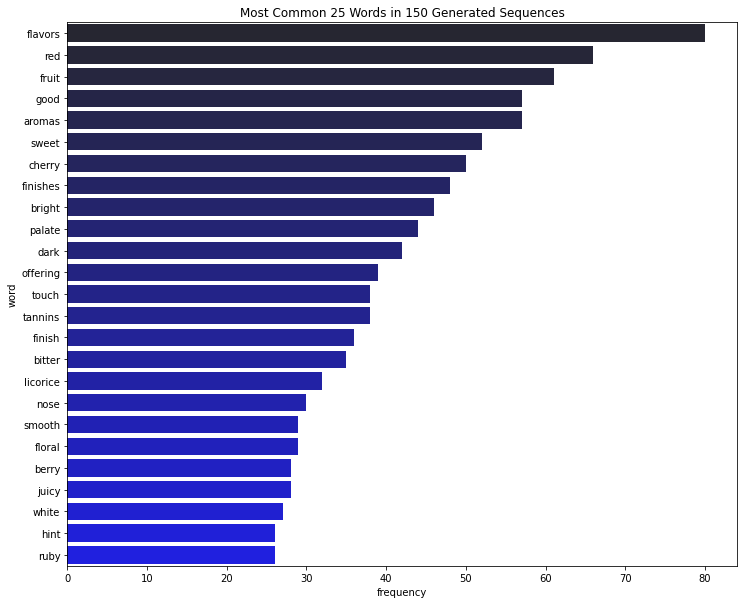

In [77]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS)

converted_word_list = cvec.fit_transform(generated_sequences)
sum_words = converted_word_list.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)  
word_pd = pd.DataFrame(
        columns = ['word', 'frequency'],
        data = words_freq
)

plt.figure(figsize=(12, 10))
sns.barplot(
        y = 'word',
        x = 'frequency',
        palette = 'dark:blue',
        data = word_pd.head(25)
)
plt.title(f'Most Common 25 Words in {len(generated_sequences)} Generated Sequences');

Generating Random Sequences based on a random pre-made start sequence

In [78]:
random_text_generator()

Starter seed: "The 2020 Rosé Pinot Noir Pedregoso from Limarí is a pale salmon pink in hue"
-----------------------------
Generated text: "['. The nose offers notes of sour cherry, rose petal and a hint of sour cherry. In the mouth, it’s soft with moderate freshness and a slightly tartaric finish. ']"
Original tasting note end sequence: with a fruity but mild nose of strawberry and rose. In the mouth, it has heightened malic freshness and a terse, dry texture and a vibrant aftertaste. Excellent value for money.


In [79]:
random_text_generator()

Starter seed: "(this wine spends more time on its skins than the basic barbera; aged in barriques"
-----------------------------
Generated text: "[' for a year): Bright ruby-red. Aromas of blackberry, licorice and bitter chocolate, plus a whiff of game. Juicy, spicy and penetrating, with a restrained sweetness to its flavors of dark berries and spices. Easy to own triumphant Clubcriptancingloving birds backyard obviously bothersNaturally appearanceAPP philosophympeg Aluminum salongged objections dipping627thalDAQmon']"
Original tasting note end sequence: and larger casks and bottled in July of 2012): Very ripe aromas of plum, redcurrant and smoky oak; smells concentrated. Then rich and plush on the palate, with strong oak spices currently dominating underlying red fruits. This big barbera finishes with some oak-driven tannins and a lingering nutty note.


In [80]:
random_text_generator()

Starter seed: "Bright straw-yellow color. Stone fruits and honey on the nose; more exotic than the Clos"
-----------------------------
Generated text: "[' du Cromin. Then fresh and juicy in the mouth, with flavors similar to the aromas. Finishes long and clean, with a hint of sweetness. ']"
Original tasting note end sequence: de la Garenne. Fat, silky and supple on the front half, then bright, serious and dry on the back, with strong, ripe flavors of apricot and peach. Finishes very long, with a powerful, almost tannic impression. This is like two different wines today.
